# CHEM 324 Final Project

Open This Notebook in [Google Collab](https://colab.research.google.com/)

Run the below shell script. THIS WILL TAKE SEVERAL MINUTES

Then Refresh the page

In [2]:
%%shell
set -e

#---------------------------------------------------#
JULIA_VERSION="1.7.1" # any version ≥ 0.7.0
JULIA_PACKAGES="IJulia BenchmarkTools Plots JSON"
JULIA_PACKAGES_IF_GPU="CUDA" # or CuArrays for older Julia versions
JULIA_NUM_THREADS=2
#---------------------------------------------------#

if [ -n "$COLAB_GPU" ] && [ -z `which julia` ]; then
  # Install Julia
  JULIA_VER=`cut -d '.' -f -2 <<< "$JULIA_VERSION"`
  echo "Installing Julia $JULIA_VERSION on the current Colab Runtime..."
  BASE_URL="https://julialang-s3.julialang.org/bin/linux/x64"
  URL="$BASE_URL/$JULIA_VER/julia-$JULIA_VERSION-linux-x86_64.tar.gz"
  wget -nv $URL -O /tmp/julia.tar.gz # -nv means "not verbose"
  tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
  rm /tmp/julia.tar.gz

  # Install Packages
  if [ "$COLAB_GPU" = "1" ]; then
      JULIA_PACKAGES="$JULIA_PACKAGES $JULIA_PACKAGES_IF_GPU"
  fi
  for PKG in `echo $JULIA_PACKAGES`; do
    echo "Installing Julia package $PKG..."
    julia -e 'using Pkg; pkg"add '$PKG'; precompile;"' &> /dev/null
  done

  julia -e 'using Pkg; Pkg.add(PackageSpec(url="https://github.com/j-hayes/JuliaChem.jl.git")); precompile;' &> /dev/null


  # Install kernel and rename it to "julia"
  echo "Installing IJulia kernel..."
  julia -e 'using IJulia; IJulia.installkernel("julia", env=Dict(
      "JULIA_NUM_THREADS"=>"'"$JULIA_NUM_THREADS"'"))'
  KERNEL_DIR=`julia -e "using IJulia; print(IJulia.kerneldir())"`
  KERNEL_NAME=`ls -d "$KERNEL_DIR"/julia*`
  mv -f $KERNEL_NAME "$KERNEL_DIR"/julia  

  echo ''
  echo "Successfully installed `julia -v`!"
  echo "Please reload this page (press Ctrl+R, ⌘+R, or the F5 key) then"
  echo "jump to the 'Checking the Installation' section."
fi

Unrecognized magic `%%shell`.

Julia does not use the IPython `%magic` syntax.   To interact with the IJulia kernel, use `IJulia.somefunction(...)`, for example.  Julia macros, string macros, and functions can be used to accomplish most of the other functionalities of IPython magics.


## Checking the Installation
The `versioninfo()` function should print your Julia version and some other info about the system:

In [2]:
versioninfo() ## makes sure julia is working

Julia Version 1.7.1
Commit ac5cc99908 (2021-12-22 19:35 UTC)
Platform Info:
  OS: Linux (x86_64-pc-linux-gnu)
  CPU: Intel(R) Xeon(R) CPU @ 2.20GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-12.0.1 (ORCJIT, broadwell)
Environment:
  JULIA_NUM_THREADS = 2


## Load the Helper Scripts

In [2]:
#=============================#
#== put needed modules here ==#
#=============================#
import JuliaChem
using JuliaChem.JCModules

#================================#
#== JuliaChem execution script ==#
#================================#
function full_rhf(input_file)
  println("--------------------------------------------------------------------------------")
  println("                       ========================================                 ")
  println("                               WELCOME TO JULIACHEM.JL!                         ")
  println("                       ========================================                 ")
  println("                                                                                ")
  println("              JuliaChem.jl is an electronic structure theory package            ")
  println("         developed by the Gordon group at Iowa State University. It is          ")
  println("        designed to apply the strengths of the Julia programming language       ")
  println("          (high-level semantics and low-level performance) to a quantum         ")
  println("                                chemistry package.                              ")
  println("                                                                                ")
  println("         For more information, refer to the following paper: Poole, D.          ")
  println("        Galvaz Vallejo, J. L.; Gordon, M. S. \"A New Kid on the Block:          ")
  println("         Application of Julia to Hartree-Fock Calculations.\" J. Chem.          ") 
  println("                     Theory Compute. 2020, 16, 8, 5006-5013.                    ")
  println("                                                                                ")
  println("       For questions on usage, email David Poole at davpoole@iastate.edu.       ")
  println("                             Jackson                                            ")
  println("--------------------------------------------------------------------------------")
 
  try
    #== read in input file ==#
    molecule, driver, model, keywords = JuliaChem.JCInput.run(input_file;       
      output=2)       
    
    #== generate basis set ==#
    mol, basis = JuliaChem.JCBasis.run(molecule, model; 
      output=2) 
   
    #== molecule info ==#
    JuliaChem.JCMolecule.run(mol)

    #== calculation driver ==# 
    if driver == "energy"
        #== perform scf calculation ==#
        if haskey(keywords, "scf")
          method = "RHF"
          if !(method == "RHF" || method == "DFRHF")
            throw("Exception: Methods other than RHF and DFRFH are not supported yet!")
          end
          rhf_energy = JuliaChem.JCRHF.Energy.run(mol, basis, keywords["scf"]; 
            output=2,) 
        else
          rhf_energy = JuliaChem.JCRHF.Energy.run(mol, basis; 
            output=2) 
        end    
        #== compute molecular properties such as dipole moment ==#
        properties = JuliaChem.JCRHF.Properties.run(mol, basis, rhf_energy, 
          keywords["prop"]; output=2)
          return rhf_energy, properties
        
    else
      throw("Exception: Only energy calculations are currently supported!")
    end
  catch e                                                                       
    bt = catch_backtrace()                                                      
    msg = sprint(showerror, e, bt)                                              
    println(msg)          
    exit()                                                                                                                            
  end 

  println("--------------------------------------------------------------------------------")
  println("                      Your calculation has run to completion!                   ")
  println("                                                                                ")
  println("                       ========================================                 ")
  println("                                   HAVE A NICE DAY!                             ")
  println("                       ========================================                 ")
  println("--------------------------------------------------------------------------------")
end


full_rhf (generic function with 1 method)

In [3]:
using JuliaChem
using JSON

function start_calculations()
    JuliaChem.initialize() 
end

"""
run a hartree fock calculation using JuliaChem 
JuliaChem must be initialized before this method is called 

Parameters: hydrogen_radius :: AbstractFloat  - The radius between the two hydrogens in Atomic Units
for the hartree fock run. 

Returns 
energy of the system in hartrees (Atomic Units)
"""
function run_h2_hartree_fock(hydrogen_radius:: AbstractFloat) :: AbstractFloat
    file_path = create_input_file(hydrogen_radius/2)
    rhf_result = full_rhf(file_path)
    return rhf_result[1]["Energy"]
end

function create_input_file(hydrogen_radius) :: String
    input_file_JSON = JSON.parsefile(joinpath(@__DIR__, "hydrogen_template.json"))
    input_file_JSON["molecule"]["geometry"][6] = hydrogen_radius
    file_path = joinpath(@__DIR__, ".//H2-radius$(hydrogen_radius).json")
    io = open(file_path, "w+")
    JSON.print(io, input_file_JSON)
    close(io)
    return file_path
end

function end_calculations()
    JuliaChem.finalize()   
end



end_calculations (generic function with 1 method)

## Modify This Code To complete the project


--------------------------------------------------------------------------------
                               WELCOME TO JULIACHEM.JL!                         
                                                                                
              JuliaChem.jl is an electronic structure theory package            
         developed by the Gordon group at Iowa State University. It is          
        designed to apply the strengths of the Julia programming language       
          (high-level semantics and low-level performance) to a quantum         
                                chemistry package.                              
                                                                                
         For more information, refer to the following paper: Poole, D.          
        Galvaz Vallejo, J. L.; Gordon, M. S. "A New Kid on the Block:          
         Application of Julia to Hartree-Fock Calculations." J. Chem.          
                     Theory Co

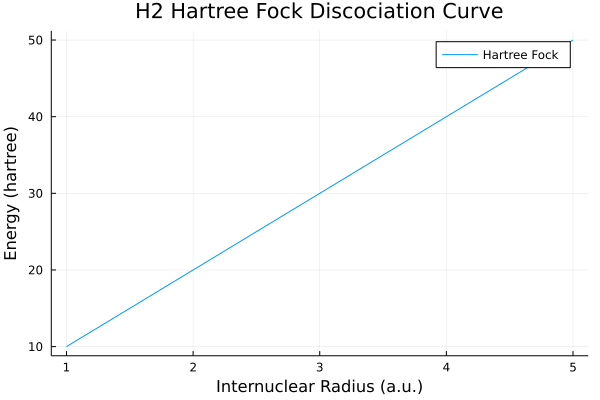

In [4]:
using JuliaChem
using Plots

function run_calculation(distance)
    start_calculations()
    
    energy = run_h2_hartree_fock(distance)     
    energy2 = run_h2_hartree_fock(distance*2) 
 
    println(energy)
    println(energy2)
    
    end_calculations()  
    
end
run_calculation(.9)

x = [1,2,3,4,5]
y = [10,20,30,40,50]
random_plot = plot(x,y, title = "H2 Hartree Fock Discociation Curve", label = "Hartree Fock")
xlabel!("Internuclear Radius (a.u.)")
ylabel!("Energy (hartree)")
